# 特徴選択（埋め込み法）
---
- Lassoを用いて、学習と同時に特徴選択を行う

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 線形回帰モデル
from sklearn.linear_model import LinearRegression
# L1正則化つき線形回帰モデル
from sklearn.linear_model import LassoCV
# 回帰問題の評価指標
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# モデルの情報を利用して特徴選択
from sklearn.feature_selection import SelectFromModel


## 2. データの読み込み
- データセット：[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
    - 20個の説明変数をもつ住宅価格のデータ
    - 目的変数は **price:	価格 [ドル]**
    - 今回は以下の**18個の説明変数**を地用
- [説明変数の意味](https://www.kaggle.com/code/hnnhytc/data-analysis-with-python)
    - bedrooms:	ベッドルームの数
    - bathrooms:	バスルームの数
    - **sqft_living:	延床面積 [平方フィート]**
    - **sqft_lot:	敷地面積 [平方フィート]**
    - floors:	階数（何階建てであるか）
    - waterfront:	海や川、湖などが見える立地か
    - view:	内見済みか
    - condition:	全体的な状態の良し悪し
    - grade:	King County の等級制度に基づく等級
    - **sqft_above:	地下室を除いた延床面積 [平方フィート]**
    - sqft_basement:	地下室の面積 [平方フィート]
    - **yr_built:	建築年**
    - yr_renovated:	改装された年
    - zipcode:	郵便番号
    - lat:	緯度座標
    - long:	経度座標
    - **sqft_living15:	2015年における延床面積**
    - **sqft_lot15:	2015年における敷地面積**

In [2]:
# CSVファイルの読み込み
df_house = pd.read_csv("../../1_data/ch7/kc_house_data.csv").drop(["id", "date"], axis=1)

# 変数の確認
display(df_house.head())
df_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## 3. 特徴選択なしで学習

### 3-1. モデルの構築・学習

In [3]:
# 特徴選択前のデータを保持
train_label = df_house["price"]
train_data = df_house.drop("price", axis=1)

# 目的変数
y = train_label.values
# 説明変数
X = train_data.values

# 線形回帰モデルの構築
regr = LinearRegression(fit_intercept=True)
# モデルの学習
regr.fit(X, y)

LinearRegression()

### 3-2. モデルの評価

In [4]:
# 値を予測
y_pred = regr.predict(X)

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3))
# RMSEを計算
rmse = np.sqrt(mean_squared_error(y, y_pred) )
print("RMSE = %s"%round(rmse, 3))
# MAPEを計算
mape = mean_absolute_percentage_error(y, y_pred) 
print("MAPE = %s"%round(mape*100,3), "%")  

MAE = 125922.646
RMSE = 201163.902
MAPE = 25.58 %


## 4. Lassoによる特徴選択
- [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)と[SelectFromModel](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)を利用

### 4-1. モデルの構築・学習

In [5]:
# estimatorにモデル（LassoCV）をセット
# 正則化の強さを自動で調整しながら、交差検証を行う
estimator = LassoCV(cv=10)

# モデルの情報を使って特徴選択を行う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

# 学習と特徴選択を実行
sfm.fit(X, y)


SelectFromModel(estimator=LassoCV(cv=10), threshold=1e-05)

### 4-2. 特徴の係数を可視化

In [6]:
# Lassoで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.00000000e+00, 0.00000000e+00, 2.37205685e+02, 7.46650294e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.45700417e+01, 3.67698927e+02,
       6.97780917e+01, 9.62998902e+01, 0.00000000e+00, 0.00000000e+00,
       8.05758593e+01, 7.60240333e-01])

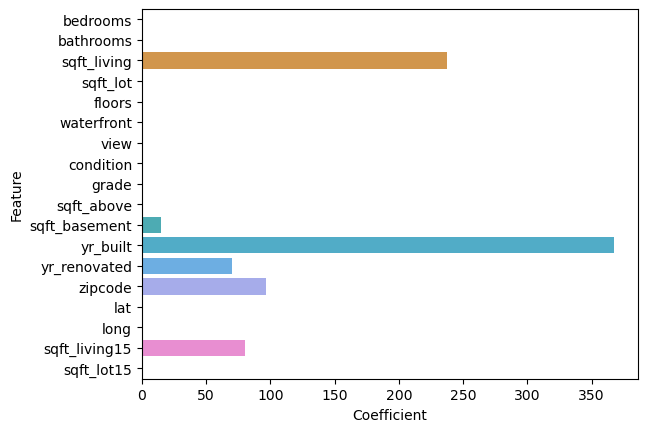

In [7]:
# データフレームを作成
df = pd.DataFrame({'Feature': train_data.columns.values, 'Coefficient': abs_coef})

# 棒グラフをプロット
sns.barplot(x='Coefficient', y='Feature', data=df)
plt.show()

### 4-3. 特徴選択の結果を確認

In [8]:
# get_support関数で使用する特徴のインデックスを取得
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True])

In [9]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'lat', 'long'],
      dtype='object')

### 4-4. 特徴の削除 

In [10]:
# 削除してもよい特徴の名前を取得する
removed_feature = train_data.columns[removed_idx]
removed_feature

# drop関数で特徴を削除
selected_X = train_data.drop(removed_feature, axis=1)
selected_X.head()

,sqft_living,sqft_lot,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,1180,5650,0,1955,0,98178,1340,5650
1,2570,7242,400,1951,1991,98125,1690,7639
2,770,10000,0,1933,0,98028,2720,8062
3,1960,5000,910,1965,0,98136,1360,5000
4,1680,8080,0,1987,0,98074,1800,7503


### 4-5. 特徴を削除した上で学習

In [11]:
# 正則化なし線形回帰モデルの学習
regr.fit(selected_X, y)
# 予測結果の取得
y_pred = regr.predict(selected_X)

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3))
# RMSEを計算
rmse = np.sqrt(mean_squared_error(y, y_pred) )
print("RMSE = %s"%round(rmse, 3))
# MAPEを計算
mape = mean_absolute_percentage_error(y, y_pred) 
print("MAPE = %s"%round(mape*100,3), "%")  

MAE = 163452.352
RMSE = 247759.025
MAPE = 34.133 %
